In [1]:
%run 'Functions.ipynb'

In [2]:
def terms_by_day(terms, start='1900-01-01', end='2020-01-01'):
    all_terms = Search(index='hep-analysis')[0:0] \
        .filter('range', earliest_date={'gte': start, 'lte': end})
    all_terms.aggs.bucket(
        'group_by_date', 
        'date_histogram', 
        field='earliest_date', 
        interval='day',
        format='date_optional_time'
    )

    given_terms = all_terms.query('match_phrase', **{'abstracts.value': terms})
    x, y = unzip(given_terms.execute().aggregations.group_by_date.buckets)
 
    if not len(y):
        return [], []
    
    total_x, total_y = unzip(all_terms.execute().aggregations.group_by_date.buckets)
    
    start = np.where(total_x == min(x))[0][0]
    end = np.where(total_x == max(x))[0][0]
    total_y = total_y[start:end+1]
        
    with np.errstate(divide='ignore', invalid='ignore'):
        normed_y = np.divide(y, total_y)
        normed_y[~ np.isfinite(normed_y)] = 0
        return x, normed_y

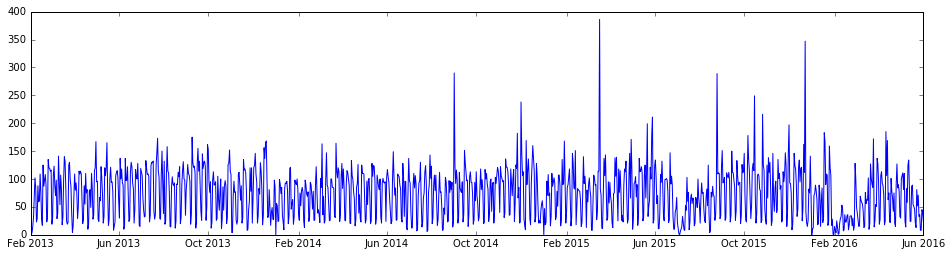

In [3]:
def all(start='1900-01-01', end='2020-01-01'):
    q = Search(index='hep-analysis')[0:0] \
    .filter('range', earliest_date={'gte': start, 'lt': end})
    q.aggs.bucket(
        'group_by_date', 
        'date_histogram', 
        field='earliest_date', 
        interval='day',
        format='date_optional_time'
    )
    return unzip(q.execute().aggregations.group_by_date.buckets)
x, y = all()
plt.plot(x, y)

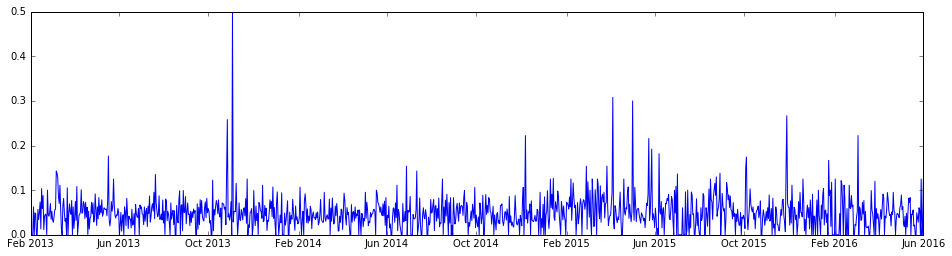

In [4]:
x, y = terms_by_day('gamma gamma')
plt.plot(x, y)

In [5]:
def repeat_sides(num, arr):
    arr = np.array(arr)
    left = np.ones(num) * arr[0]
    right = np.ones(num) * arr[-1]
    return np.append(left, np.append(arr, right))

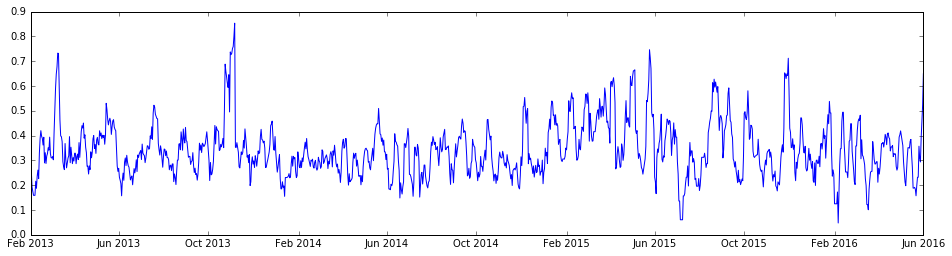

In [6]:
ay = sp.signal.convolve(repeat_sides(3, y), [1, 1, 1, 1, 1, 1, 1], mode='valid')
plt.plot(x, ay)

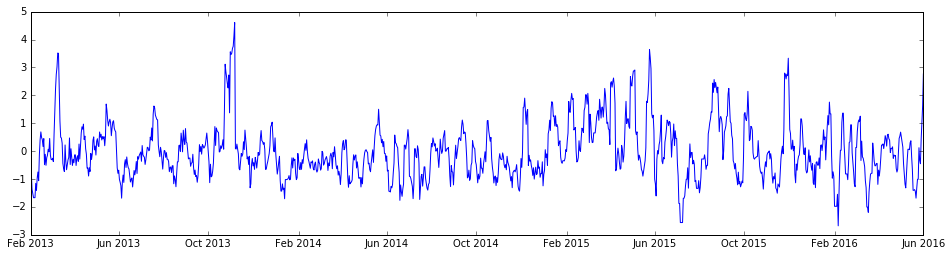

In [7]:
sy = sp.stats.zscore(ay)
plt.plot(x, sy)

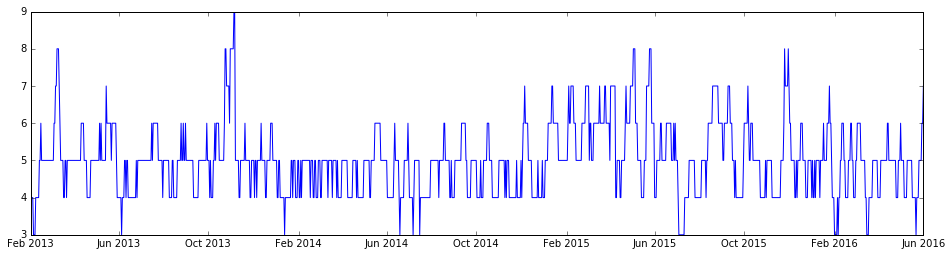

In [8]:
dy = np.digitize(sy, np.linspace(-5, 5, 10))
plt.plot(x, dy)

In [203]:
raw = fold_vectors(term_vectors(interval_ids('2015-01-01', days=31), 'abstracts.value'))

In [207]:
selected = {}
for k, v in sorted(raw.items()):
    if v['doc_freq'] >= 5:
        selected[k] = v

In [208]:
terms = sorted(selected.items(), key=lambda x: -x[1]['doc_freq'])

In [209]:
len(terms)

5805

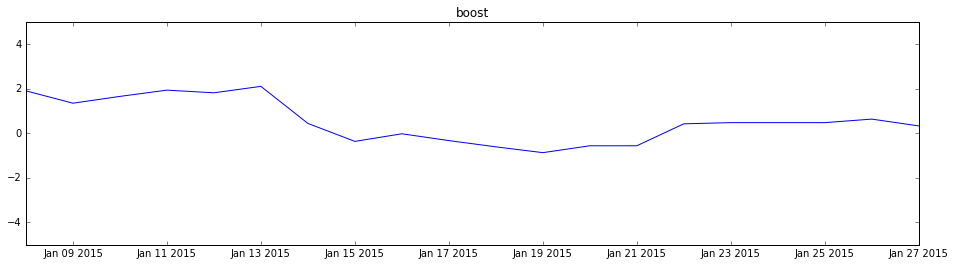

In [13]:
marked = []
unmarked = []

for term, _ in terms:

    x, y = terms_by_day(term, start='2015-01-01', end='2015-01-31')
    tx, ty = terms_by_day(term)
    
    if not len(y):
        continue
    
    ay = sp.signal.convolve(y, [1, 1, 1, 1, 1, 1, 1], mode='valid')
    aty = sp.signal.convolve(ty, [1, 1, 1, 1, 1, 1, 1], mode='valid')

    x = x[3:-3]
    tx = tx[3:-3]

    sy = (ay - np.mean(aty)) / np.std(aty)
    sty = (aty - np.mean(aty)) / np.std(aty)

    plt.gca().cla()

    plt.title(term)
    plt.ylim(-5, 5)
    plt.plot(x, sy)
    #plt.plot(tx, sty)
    
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf()) 
    
    command = input()
    if command == 'q':
        break
    elif command == 'a': # add mark
        marked.append(term)
    elif command == 'd': # delete mark
        unmarked.append(term)
        
IPython.display.clear_output()

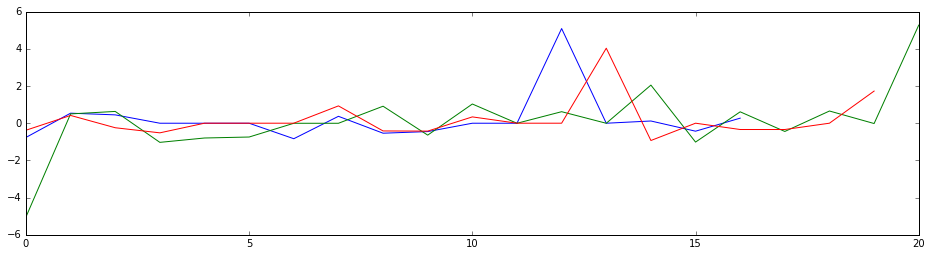

In [15]:
higher = []
lower = []

for term, _ in terms:

    x, y = terms_by_day(term, start='2015-01-01', end='2015-01-31')
    tx, ty = terms_by_day(term)
    
    if not len(y):
        continue
    
    ay = y
    aty = ty
    ay = sp.signal.convolve(ay, [1, -1], mode='valid')
    ay = sp.signal.convolve(ay, [1, 1, 1, 1, 1, 1, 1], mode='valid')
    aty = sp.signal.convolve(aty, [1, -1], mode='valid')
    aty = sp.signal.convolve(aty, [1, 1, 1, 1, 1, 1, 1], mode='valid')

    x = x[4:-4]
    tx = tx[4:-4]
    
    sy = (ay - np.mean(aty)) / np.std(aty)
    sty = (aty - np.mean(aty)) / np.std(aty)
    
    if sy[np.argmax(sy)] >= 4:
        plt.plot(sy)
        higher.append(term)
    else:
        lower.append(term)

In [16]:
for term, _ in terms:

    x, y = terms_by_day(term, start='2015-01-01', end='2015-01-31')
    tx, ty = terms_by_day(term)
    
    if not len(y):
        continue

In [17]:
higher

['shear', 'heavy quark', 'viscosity']

In [211]:
mapped = []

for term, _ in terms:

    x, y = terms_by_day(term, start='2015-01-01', end='2015-01-31')
    tx, ty = terms_by_day(term)
    
    if not len(y) or len(ty) < 7:
        continue
    
    before = x[0].day - 1
    after = 31 - x[-1].day
    y = np.append(np.zeros(before), y)
    y = np.append(y, np.zeros(after))
    
    ay = sp.signal.convolve(y, [1, 1, 1, 1, 1, 1, 1], mode='valid')
    aty = sp.signal.convolve(ty, [1, 1, 1, 1, 1, 1, 1], mode='valid')

    tx = tx[3:-3]

    sy = (ay - np.mean(aty)) / np.std(aty)
    dy = np.digitize(sy, np.linspace(-5, 5, 10))
    
    ly = [chr(97 + n) for n in dy]
    
    mapped.append((term, dy))

In [131]:
ref = 5 * np.ones_like(mapped[0][1])

In [212]:
len(mapped)

5788

In [46]:
from sklearn import metrics

In [67]:
v1 = [[1, 2, 4]]
v2 = [[1, 1, 3]]

In [213]:
metrics.pairwise_distances(v1, v2, metric='manhattan')

array([[ 2.]])

In [214]:
scored = [metrics.pairwise_distances([e], [ref], metric='manhattan')[0] for t, e in mapped]

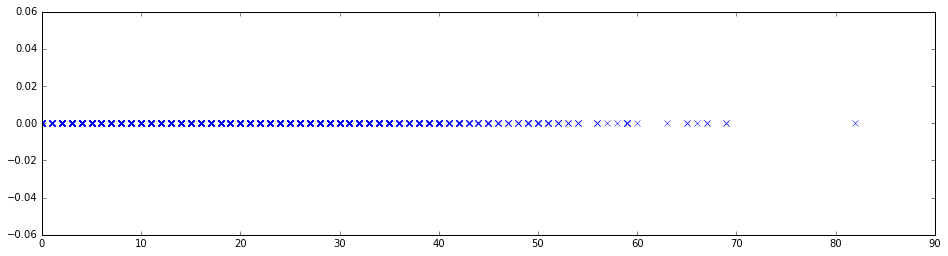

In [215]:
plt.plot(scored, np.zeros(len(scored)), 'x')

In [216]:
len(scored)

5788

In [217]:
from sklearn.cluster import KMeans

In [225]:
X = np.array([e for _, e in mapped])
len(X[0])

25

In [337]:
km = KMeans(n_clusters=5)
y_pred = km.fit_predict(X)

In [237]:
X[y_pred]

array([[3, 4, 5, ..., 6, 5, 4],
       [5, 6, 6, ..., 5, 5, 4],
       [3, 4, 5, ..., 6, 5, 4],
       ..., 
       [5, 6, 6, ..., 5, 5, 4],
       [3, 4, 5, ..., 6, 5, 4],
       [5, 6, 6, ..., 5, 5, 4]])

In [238]:
len(y_pred)

5788

In [239]:
from sklearn.decomposition import PCA

In [243]:
p = PCA(n_components=3).fit_transform(X)

In [250]:
from mpl_toolkits.mplot3d import Axes3D

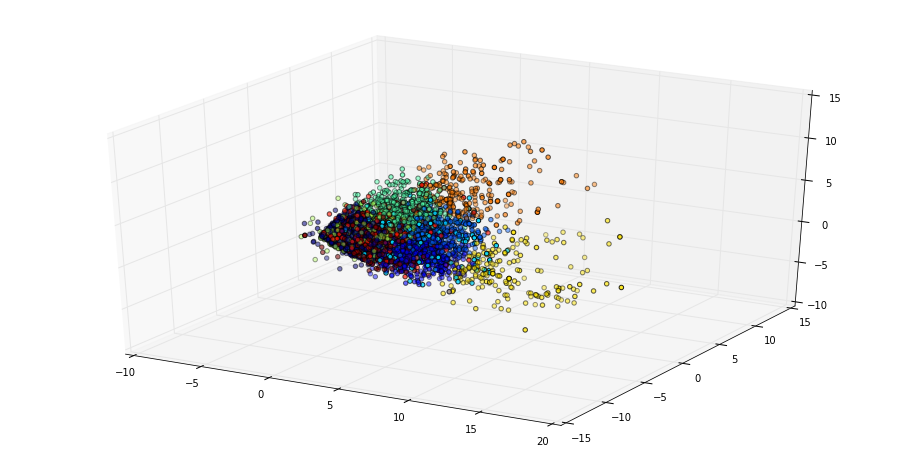

In [271]:
ax = plt.subplot(projection='3d')
ax.scatter(p[:, 0], p[:, 1], p[:, 2], c=y_pred)

In [270]:
%matplotlib inline 
# notebook
pylab.rcParams['figure.figsize'] = (16, 8)

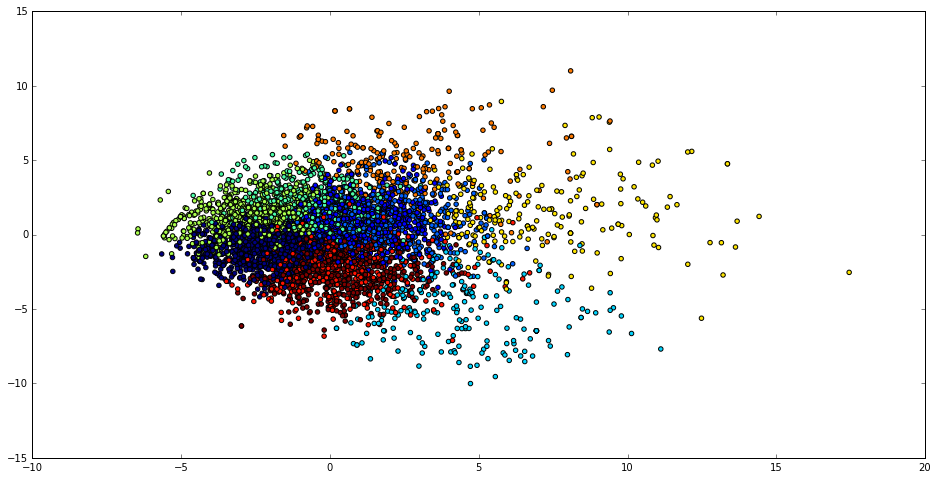

In [272]:
plt.scatter(p[:, 0], p[:, 1], c=y_pred)

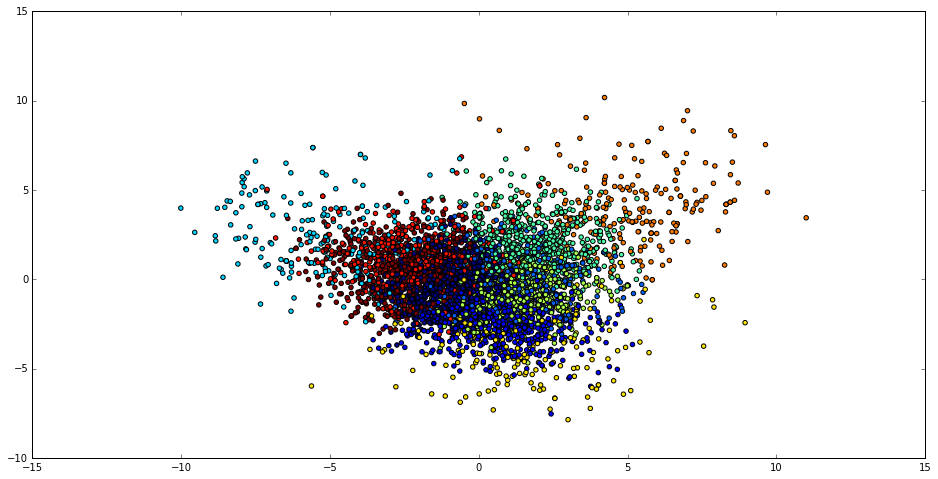

In [274]:
plt.scatter(p[:, 1], p[:, 2], c=y_pred)

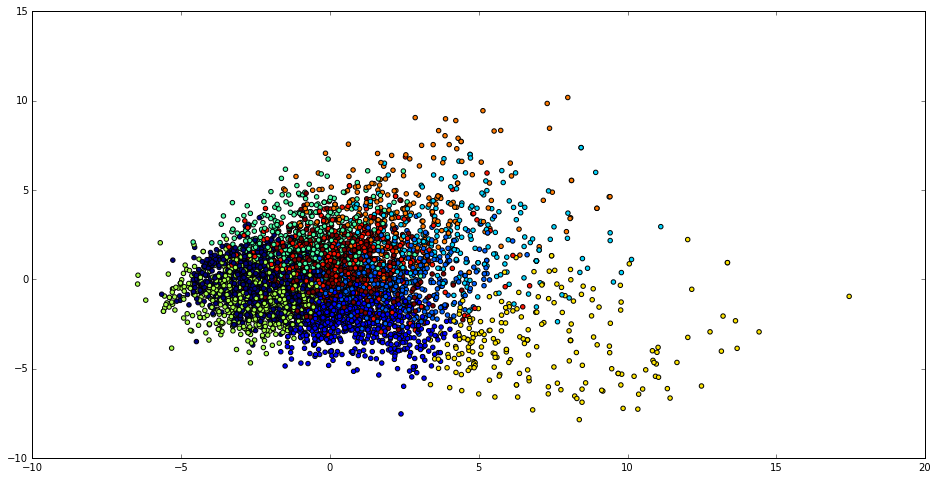

In [273]:
plt.scatter(p[:, 0], p[:, 2], c=y_pred)

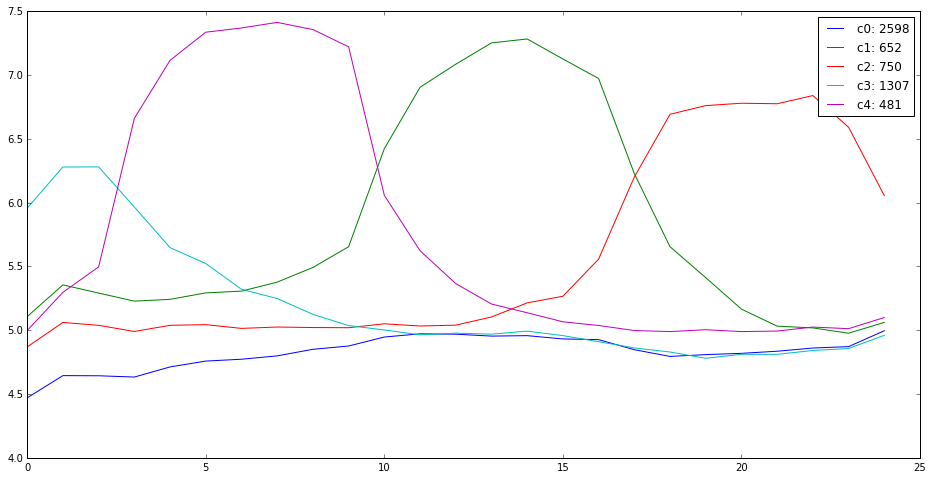

In [338]:
for i, center in enumerate(km.cluster_centers_):
    plt.plot(center, label='c%d: %d' % (i, np.count_nonzero(y_pred == i)))
plt.legend()

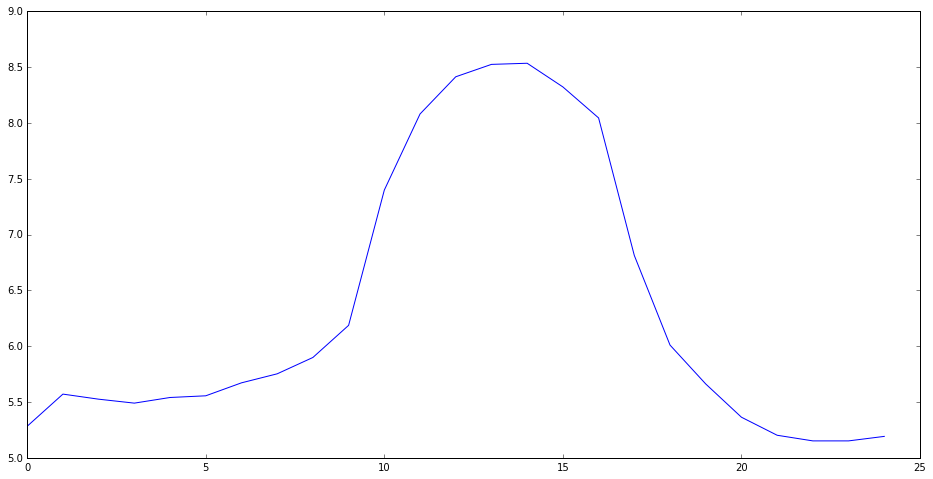

In [334]:
plt.plot(km.cluster_centers_[2])

In [293]:
mapped[:5]

[('use',
  array([3, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6,
         5, 4])),
 ('model',
  array([3, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 4, 4, 4, 4, 4, 4,
         4, 5])),
 ('result',
  array([4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6,
         6, 6])),
 ('can',
  array([4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 5, 5, 5, 5, 4, 4, 4, 4, 5, 5,
         5, 5])),
 ('energy',
  array([4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6,
         5, 5]))]

In [314]:
label = np.array([t for t, s in mapped])

array(['use', 'model', 'result', 'can', 'energy'], 
      dtype='<U32')

In [336]:
for i, cluster in enumerate(y_pred):
    
    if cluster == 5:
        print(mapped[i][0])
        

paper
temperature
important
finally
apply
meson
fermion
end
gluon
development
integrate
length
semi
phi
making
usual
quark gluon
localize
whole
opportunity
gluon plasma
quark gluon plasma
rhic
highlight
suppression
phase diagram
finite temperature
energy momentum
calculating
regular
hawking
every
electrical
incorporate
single particle
truncate
interference
nevertheless
lighter
begin
ago
gordon
rank
calculation perform
disperse
hole mass
discuss possible
first result
properly
triplet
auxiliary
black hole mass
eddington
loud
qgp
klein gordon
paper investigate
implicit
fermi large
fermi large area
radio loud
conflict
ff
room
can derive
plasma qgp
psr
plate
gluon plasma qgp
strong interact
mass ray
self energy
momentum dependent
riemannian
casimir
also study
accordance
strict
heavy nuclei
investigate effects
analysis base
schwarzschild black
genus
keplerian
review recent
persistent
fragmentation function
schwarzschild black hole
advances
ect
riemann surface
fermi gas
semi inclusive
phenix


In [301]:
y_pred

array([4, 1, 4, ..., 6, 4, 6], dtype=int32)

In [331]:
np.count_nonzero(y_pred == 9)

410